<a href="https://colab.research.google.com/github/ifyyy10/Breast-Cancer-Classifier/blob/main/Breast_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT ALL LIBRARIES AND MOUNT GOOGLE DRIVE

In [ ]:
!pip install wget

In [ ]:
# import all libraries
import os
import wget
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input



# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LOAD DATASET

In [ ]:
# Define paths
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'  # Update with your dataset path
unknown_folder = os.path.join(base_dir, 'unknown')

POPULATE UNKNOWN FOLDER WITH RANDOM IMAGES

In [ ]:
## populate unknown folder with random images

# Define how many random images you want to download
num_images = 300  # Set this to the number of random images you need

# Download random images from Lorem Picsum
for i in range(num_images):
    image_url = f"https://picsum.photos/200/300?random={i}"  # 200x300 random image
    image_path = os.path.join(unknown_folder, f'random_image_{i}.jpg')
    wget.download(image_url, image_path)

print(f'{num_images} random images downloaded into the unknown folder.')

KeyboardInterrupt: 

PRE-PROCESS DATA

In [ ]:
# Define Image Dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


# Create an ImageDataGenerator with a 20% validation split (define preprocessing strategy)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Load and preprocess data

# Training generator
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)

Found 1743 images belonging to 4 classes.
Found 435 images belonging to 4 classes.


CALCULATE CLASS WEIGHT

In [ ]:
# Get class labels from the training generator
class_labels = train_generator.classes

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', # ensures each class gets a balanced weight
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to dictionary for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)


{0: 0.6111500701262272, 1: 1.293026706231454, 2: 2.045774647887324, 3: 0.9078125}


Build the Model Using DenseNet121

In [ ]:
# Define input layer
input_tensor = Input(shape=(224, 224, 3))

# Load the base model with the input tensor
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the base model to prevent its weights from updating during initial training
base_model.trainable = False

# Define the custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x) # takes output of densenet model and reduces it to a smaller, manageable size for the dense layers.
x = Dense(256, activation='relu')(x) # introduce non-linearity whuch will help the model learn complex patterns
x = Dropout(0.5)(x) # randomly drop 50% of the units during training to reduce overfitting
output_tensor = Dense(4, activation='softmax')(x)  # softmax activation ensures that the output values represent probabilities for each class.



# Define the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

  TRAIN THE MODEL

In [ ]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 780s 12s/step - accuracy: 0.6200 - loss: 0.9514 - val_accuracy: 0.8253 - val_loss: 0.3893
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 401s 7s/step - accuracy: 0.8297 - loss: 0.4406 - val_accuracy: 0.8483 - val_loss: 0.3707
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 406s 7s/step - accuracy: 0.8186 - loss: 0.3868 - val_accuracy: 0.8598 - val_loss: 0.3359
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 403s 7s/step - accuracy: 0.8260 - loss: 0.3787 - val_accuracy: 0.8391 - val_loss: 0.3856
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 428s 8s/step - accuracy: 0.8472 - loss: 0.3544 - val_accuracy: 0.8368 - val_loss: 0.3703
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 418s 8s/step - accuracy: 0.8705 - loss: 0.3028 - val_accuracy: 0.8322 - val_loss: 0.3339
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 537s 9s/step - accuracy: 0.8647 - loss: 0.3248 - val_accuracy: 0.8506 - val_loss: 0.3374
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 416s 7s/step - accuracy: 0.8711 - loss: 0.2945 - val_accuracy: 0.8575 - val_loss: 0

FINE TUNE THE DENSE NET

In [ ]:
# Unfreeze some layers of DenseNet for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


FINAL TRAINING OF THE MODEL WITH FINE-TUNING

In [ ]:
# Continue training the model with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=5,  # reduce epochs to avoid overfitting
    validation_data=validation_generator,
    class_weight=class_weights_dict,  # Continue handling class imbalance
    callbacks=[early_stopping]
)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1523s 26s/step - accuracy: 0.3422 - loss: 8.2565 - val_accuracy: 0.8506 - val_loss: 0.3924
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1427s 25s/step - accuracy: 0.6797 - loss: 1.4318 - val_accuracy: 0.7816 - val_loss: 0.6061
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1367s 25s/step - accuracy: 0.8465 - loss: 0.4220 - val_accuracy: 0.8000 - val_loss: 0.4746
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1376s 25s/step - accuracy: 0.8617 - loss: 0.4393 - val_accuracy: 0.8460 - val_loss: 0.4092
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1392s 25s/step - accuracy: 0.8311 - loss: 0.4714 - val_accuracy: 0.8621 - val_loss: 0.3690


SAVE TRAINED MODEL

In [ ]:
# Save the model after training
model.save('/content/drive/My Drive/breast_cancer_classifier.h5')

PLOT TRAINING VS VALIDATION

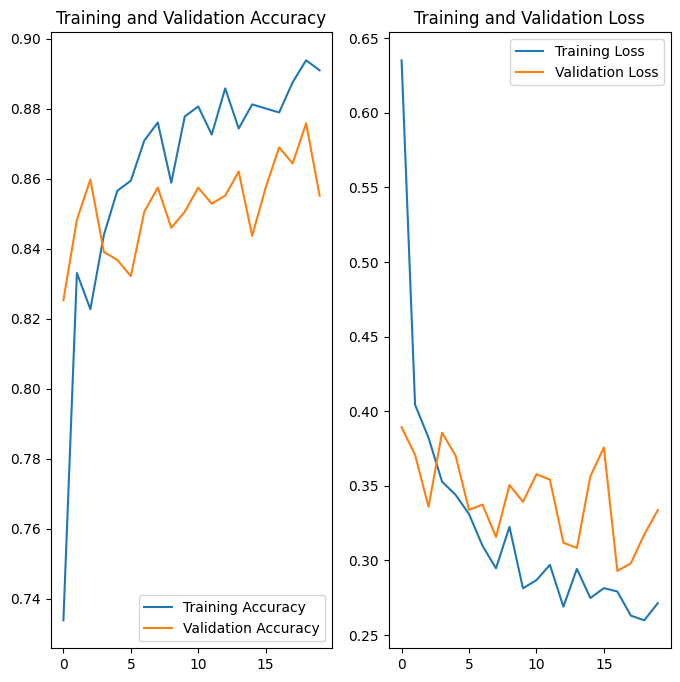

In [ ]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


CHECK FOR PREDICTION STRENGTH USING CONFUSION MATRIX

14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step


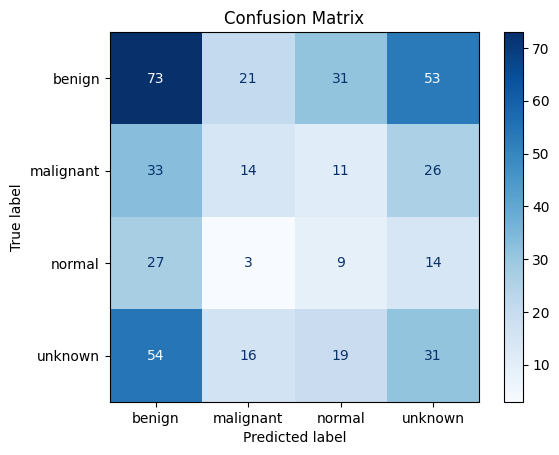

In [ ]:
# Step 1: Get the true labels and predicted labels

# Predict the labels for the validation dataset
y_pred = model.predict(validation_generator)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = validation_generator.classes

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Visualize the confusion matrix
labels = list(validation_generator.class_indices.keys())  # Class names (e.g., ['benign', 'malignant', 'normal', 'unknown'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


CREATE GUI FOR TESTING MODEL

In [ ]:
# Path to your model in Google Drive
model_path = '/content/drive/My Drive/breast_cancer_classifier.h5'

# Load the pre-trained model
model = load_model(model_path)

# Check the model summary to ensure it's loaded correctly
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,300,934 (27.85 MB)

 Trainable params: 7,217,284 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
import io  # To handle the byte conversion

# Step 1: Create Widgets

# File upload widget for image upload
file_upload = widgets.FileUpload(
    accept='image/*',  # Accept images only
    multiple=False  # Single file upload
)

# Button to trigger prediction
predict_button = widgets.Button(
    description="Predict",
    button_style="success"  # Green color button
)

# Output widget to display image and prediction
output = widgets.Output()

# Label widget to show the prediction
prediction_label = widgets.Label("Prediction: ")

# Step 2: Define Prediction Function

def on_file_upload(change):
    """Handle image upload and display the image."""
    clear_output(wait=True)
    uploaded_file = list(change['new'].values())[0]
    img_data = uploaded_file['content']

    # Convert bytes to an image
    img = Image.open(io.BytesIO(img_data))

    with output:
        clear_output()
        display(img)

    return img

def make_prediction(img):
    """Predict the class of the uploaded image."""
    img = img.convert('RGB')  # Ensure the image is in RGB mode
    img = img.resize((224, 224))  # Resize image to fit the model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess input as expected by DenseNet

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class, predictions


def on_predict_clicked(b):
    """Handle the click event for the prediction button."""
    with output:
        clear_output()

        # Convert file content to image and display
        uploaded_file = list(file_upload.value.values())[0]
        img_data = uploaded_file['content']

        # Load image from bytes
        img = Image.open(io.BytesIO(img_data))
        display(img)

        # Make prediction
        predicted_class, predictions = make_prediction(img)

        # Display prediction result
        class_names = ['Benign', 'Malignant', 'Normal', 'Unknown']  # Modify as per your class names
        predicted_label = class_names[predicted_class]
        prediction_label.value = f"Prediction: {predicted_label} (Confidence: {predictions[0][predicted_class]*100:.2f}%)"

# Step 3: Event Handlers and GUI Display

# Attach file upload event
file_upload.observe(on_file_upload, names='value')

# Attach predict button click event
predict_button.on_click(on_predict_clicked)

# Display the widgets
display(widgets.VBox([file_upload, predict_button, output, prediction_label]))